# **Accessing Data from Kaggle**

In [ ]:
#The dataset is too large to be downloaded to our local computers.  So instead, we utilized both kaggle and google colabratory to write our code.  Through both of these platforms we were able to 
#access the code; however, these platforms only provide so much memory.  Due to this limitation, we were unable to complete all of the models we had originally planned for. 
! pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"schuke03","key":"6f671367151c2c2c7c6c7caf548da029"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d chrisfilo/fruit-recognition

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 7.91G/7.92G [02:00<00:00, 66.5MB/s]
100% 7.92G/7.92G [02:00<00:00, 70.3MB/s]


In [ ]:
import zipfile
local_zip = 'fruit-recognition.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./database')
zip_ref.close()

# **Data loading and Cleaning**

In [ ]:
# Load the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#To access our data images, we utilized code from kaggle that demonstarted how to load the fruit and path name into a df.  This df could then be used to get access to the images from the path, allowing 
#us to work with this dataset
def load_images_from_folder(folder,only_path = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [ ]:
# Load the paths on the images
images = []
dirp = "./database/"
for f in os.listdir(dirp):
    if "png" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else:
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)

In [ ]:
#Here we created a df based on the fruit name and the path to access the image
df = pd.DataFrame(images, columns = ["fruit", "path"])

In [ ]:
#Visualize how the df looks after being loaded
df.head()

,fruit,path
0,Pitaya,./database/Pitaya/Pitaya00822.png
1,Pitaya,./database/Pitaya/Pitaya002387.png
2,Pitaya,./database/Pitaya/Pitaya001629.png
3,Pitaya,./database/Pitaya/Pitaya00496.png
4,Pitaya,./database/Pitaya/Pitaya00531.png


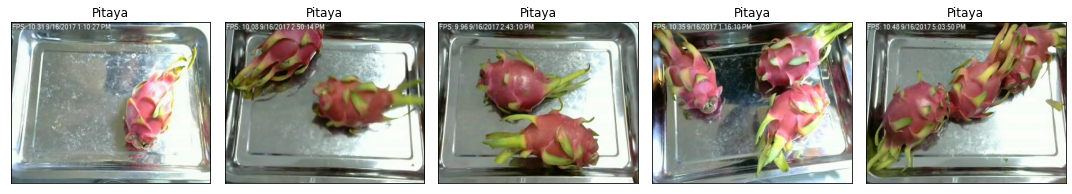

In [ ]:
# Display 5 pictures of the dataset with their labels.  Here we are displaying the first 5 images that are present in the data.  Each of the images is of a pitaya; however, this gives an 
#idea of how the images were taken.  The backgrounds were all the same, but the lighting, pose, and number of fruit differed between images.  The difference between images in the same category
#was in hopes to make the model more robust when performing recognition/identification.

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i])
plt.tight_layout()
plt.show()

In [ ]:
#Next we checked to see how many images were present within each category.  This dataset began with ~44,000 images which is very large.  We decided to reduce our data by removing images from each of 
#the categories so that each category had 1000 images and the overall dataset was reduced to 15,000 images.  We were originally going to only remove images from the larger categories such as Guava, 
#Apple, and Kiwi; however, the dataset remained quite large and we felt 15,000 images would be sufficient instead.
df['fruit'].value_counts()

Guava          19698
Apple          11185
Kiwi            8465
Mango           4154
Banana          3027
Pear            3012
Orange          3012
Peach           2629
Pitaya          2501
Plum            2298
Tomatoes        2171
Pomegranate     2167
Carambola       2080
muskmelon       2078
Persimmon       2072
Name: fruit, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


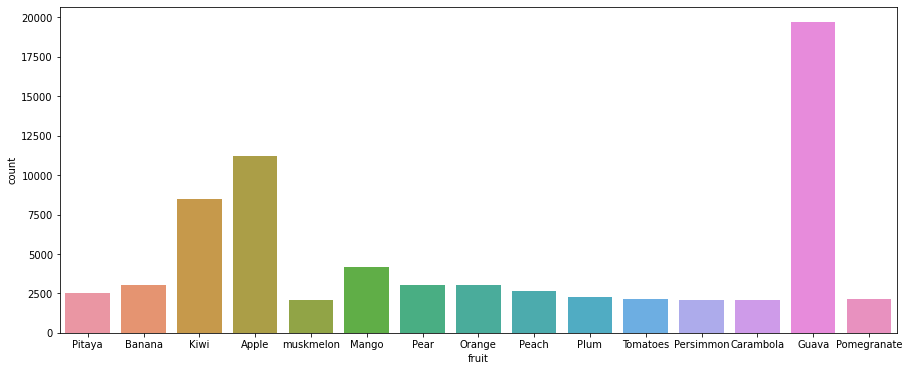

In [ ]:
#We visualized the original distribution of our data between the classes.  We can see again that Apple, Kiwi, and Guava make the dataset a little unbalanced which was addressed during removal of some 
#images
import seaborn as sbn
plt.figure(figsize=(15, 6))
sbn.countplot(df['fruit'])

In [ ]:
'''
We randomly removed images from each of the 15 categories.  For each category, we only kept 1000 images to work with for our model.  It is important to note that because we had to separate our notebooks
for color and grayscale models, this randomization will be different between notebooks.  The models may end up with different images within the 15,000 images that are randomly chosen.  This should not largely
affect the performance of the models we have chosen to run.  It is also possible that there is a loss of the different image types (lighting, pose, number), which could also potentially affect the success
of our models
'''

remove_guava = np.random.choice(df[df['fruit']=='Guava'].index,size=18698,replace=False)
df.drop(remove_guava, inplace=True)

remove_apple = np.random.choice(df[df['fruit']=='Apple'].index,size=10185,replace=False)
df.drop(remove_apple, inplace=True)

remove_kiwi = np.random.choice(df[df['fruit']=='Kiwi'].index,size=7465,replace=False)
df.drop(remove_kiwi, inplace=True)

remove_mango = np.random.choice(df[df['fruit']=='Mango'].index,size=3154,replace=False)
df.drop(remove_mango, inplace=True)

remove_banana = np.random.choice(df[df['fruit']=='Banana'].index,size=2027,replace=False)
df.drop(remove_banana, inplace=True)

remove_orange = np.random.choice(df[df['fruit']=='Orange'].index,size=2012,replace=False)
df.drop(remove_orange, inplace=True)

remove_pear = np.random.choice(df[df['fruit']=='Pear'].index,size=2012,replace=False)
df.drop(remove_pear, inplace=True)

remove_peach = np.random.choice(df[df['fruit']=='Peach'].index,size=1629,replace=False)
df.drop(remove_peach, inplace=True)

remove_pitaya = np.random.choice(df[df['fruit']=='Pitaya'].index,size=1501,replace=False)
df.drop(remove_pitaya, inplace=True)

remove_plum = np.random.choice(df[df['fruit']=='Plum'].index,size=1298,replace=False)
df.drop(remove_plum, inplace=True)

remove_tomatoes = np.random.choice(df[df['fruit']=='Tomatoes'].index,size=1171,replace=False)
df.drop(remove_tomatoes, inplace=True)

remove_pom = np.random.choice(df[df['fruit']=='Pomegranate'].index,size=1167,replace=False)
df.drop(remove_pom, inplace=True)

remove_cara = np.random.choice(df[df['fruit']=='Carambola'].index,size=1080,replace=False)
df.drop(remove_cara, inplace=True)

remove_musk = np.random.choice(df[df['fruit']=='muskmelon'].index,size=1078,replace=False)
df.drop(remove_musk, inplace=True)

remove_persimmon = np.random.choice(df[df['fruit']=='Persimmon'].index,size=1072,replace=False)
df.drop(remove_persimmon, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


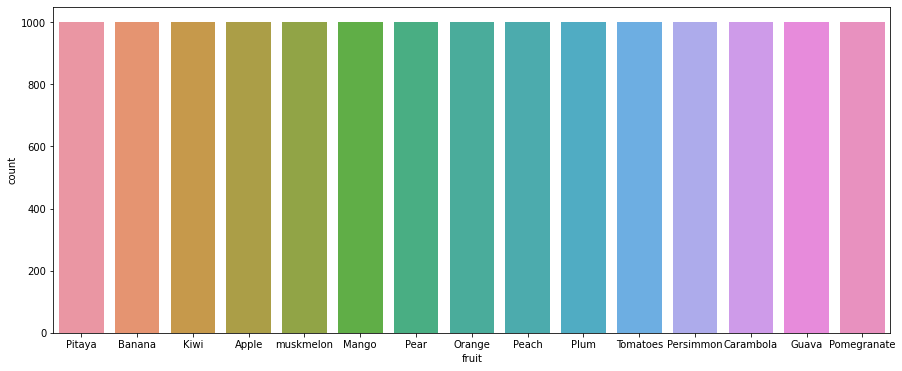

In [ ]:
#After removing images, we can see that each fruit category now has 1000 images
import seaborn as sns
plt.figure(figsize=(15, 6))
sns.countplot(df['fruit'])

In [ ]:
#The images were removed randomly, impacting the index of our dataframe.  To fix the indexing we reset the index so it now runs from 0-14999
df.reset_index(drop=True, inplace=True)
df

,fruit,path
0,Pitaya,./database/Pitaya/Pitaya00822.png
1,Pitaya,./database/Pitaya/Pitaya00693.png
2,Pitaya,./database/Pitaya/Pitaya001289.png
3,Pitaya,./database/Pitaya/Pitaya002276.png
4,Pitaya,./database/Pitaya/Pitaya002091.png
...,...,...
14995,Pomegranate,./database/Pomegranate/Pomegranet001159.png
14996,Pomegranate,./database/Pomegranate/Pomegranet00586.png
14997,Pomegranate,./database/Pomegranate/Pomegranet001808.png
14998,Pomegranate,./database/Pomegranate/Pomegranet002151.png


In [ ]:
'''
We then shuffled the dataset so that the fruit categories were not all in order.  This is important when creating training and testing sets so that each set contains images from the different categories.
We also created a label column which gave each fruit a number label that would be used for our modeling
'''
# shuffle dataset
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Assign to each fruit a specific number
fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

{'Apple': 0, 'Banana': 1, 'Carambola': 2, 'Guava': 3, 'Kiwi': 4, 'Mango': 5, 'Orange': 6, 'Peach': 7, 'Pear': 8, 'Persimmon': 9, 'Pitaya': 10, 'Plum': 11, 'Pomegranate': 12, 'Tomatoes': 13, 'muskmelon': 14}


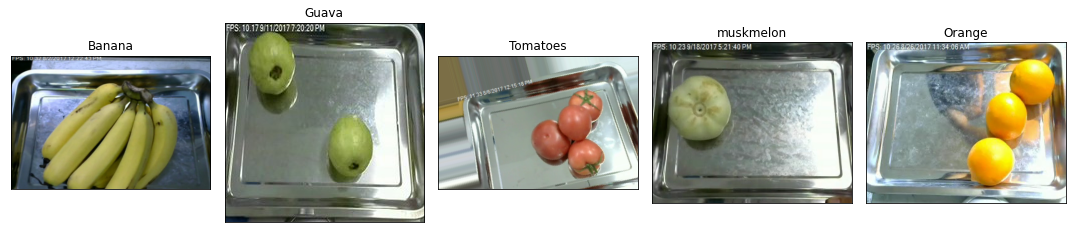

In [ ]:
#Through displaying the first 5 images again, we can see that the dataset has been shuffled and we now see a variety of the different fruits present in the data
# Display 5 pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i])
plt.tight_layout()
plt.show()

# Classical Machine Learning

In [ ]:
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [ ]:
#Using the path which is stored in the df, this function loads the images and returns the list of images.  It also returns the labels which correspond to each image.  Within this function, the images
#are also reshaped to be 150x150 which again aids in reducing the amount of data.  The original pixel size was 320x~258
def load_img(df):
# Load the images using their contained in the dataframe df
# Return a list of images and a list with the labels of the images
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  cv2.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [ ]:
#Here the load_img function is used to load the images into the X and labels into the y.  Once we have the X and y we will be able to create training and testing sets that can be used to train
#our model
X,y = load_img(df)

In [ ]:
#we can see here that the shape of our X is 15000, 150, 150, 3.  This shows us that there are 15000 rows with images that are 150x150.  The 3 indicates that the images are in color or RBG
print("The shape of X is", X.shape)
print("The shape of y is", y.shape)

The shape of X is (15000, 150, 150, 3)
The shape of y is (15000,)


In [ ]:
# splitting X and y into training and testing sets.  Here we did an 80/20 split so 80% of the data is used to train the model and 20% is used to test the model with novel data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

In [ ]:
#We can then see that the training set consists of 12,000 rows and the test set contains 3000 rows.  The other values remain the same for image size (150x150) and channel (3)
print("The shape of X_train is", X_train.shape)
print("The shape of X_test is", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_test is", y_test.shape)

The shape of X_train is (12000, 150, 150, 3)
The shape of X_test is (3000, 150, 150, 3)
The shape of y_train is (12000,)
The shape of y_test is (3000,)


In [ ]:
#We then convert the shape of the data by flattening it.  This results in 12,000 rows for the training set with 67,500.  The 67,500 came from multiplying the 150x150x3.  We also did the same
#for the test set so the new shape was 3000x67500
X_train = X_train.reshape(12000,150*150*3)
X_test = X_test.reshape(3000, 150*150*3)

In [ ]:
#Here we checked the shape after doing the reshaping prior to training the SGD classifier
print("The shape of X_train after reshaping is", X_train.shape)
print("The shape of X_test after reshaping is", X_test.shape)

The shape of X_train after reshaping is (12000, 67500)
The shape of X_test after reshaping is (3000, 67500)


In [ ]:
#We decided to use the SGD classifier as our classical machine learning model.  We used the x and y training sets to fit our data into a model
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
#We then calculated the accuracy of the model using cross validation.  From this we can see that the accuracy ranged from 0.71-0.78, which is not horrible, but could be better.  I expect that the deep
#learning model will perform better than this classical machine learning model.
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.783  , 0.783  , 0.71675])

'\nBased on this confusion matrix, it appears that the most mislabeling happened for label 6(orange).  This label was mistaken for labels 1,2, and 5 pretty frequently as far as missed labeling goes.\nThese labels correspond to banana, carambola, and mango.  I find it pretty surprising that an orange was mistaken for a banana as much as this confuson matrix indicates.  Both the color and shape\nof these fruits are very different. However, I can see how the mango and orange were mislabeled as one another.  Both of these fruits have more orange in them as well as a rounder shape.  I am unfamiliar \nwith what a carambola is; however, based on the images I have seen this fruit appears to be more green, so maybe the rounder shape casued the mislabeling for this area.\n'

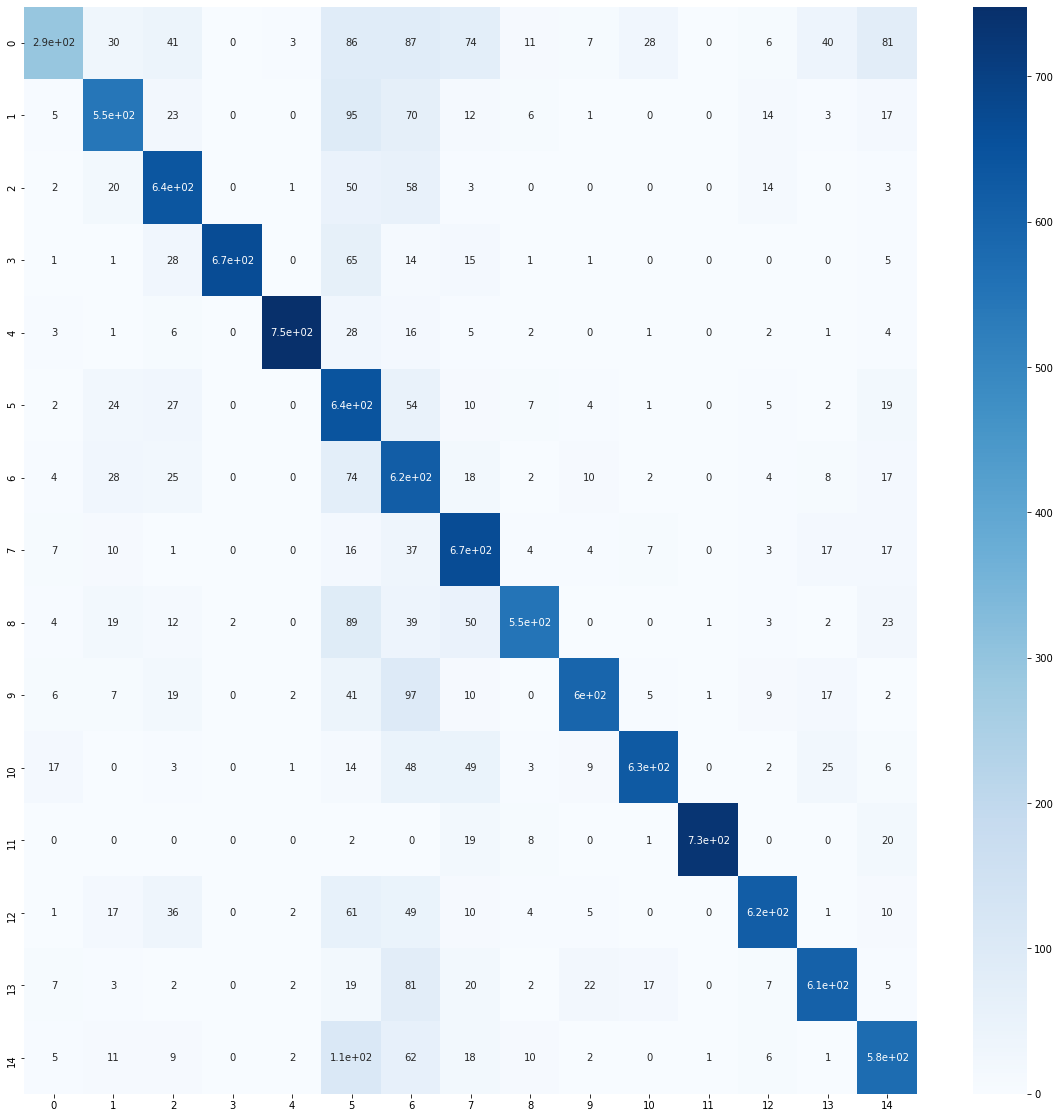

In [ ]:
#Created a confusion matrix to see what labels our model struggled to classify.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
cm=confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, cmap = 'Blues')

'''
Based on this confusion matrix, it appears that the most mislabeling happened for label 5 (mango).  This label was mistaken for labels 14, 8, and 1 most frequently as far as missed labeling goes.
These labels correspond to muskmelon, pear, and banana.  I find it pretty surprising that a mango was mistaken for a banana as much as this confuson matrix indicates.  Both the color and shape
of these fruits are very different. However, I can see how the mango and muskmelon/pear were mislabeled as one another.  Both of these fruits are more spherical; however, the colors do not seem as 
similar to me.  It is hard to tell whether the model performed better with shape or color. This will be an interesting comparison to the grayscale version
'''

In [ ]:
#We also ran our test sets through the model to evaluate how they performed.  The accuracy ranged from 0.61-0.72, which is lower than the training set.  This may indictae that the model did not 
#do as well when given novel data to label.  This could potentially be contributed to which fruits were seen in the training vs testing sets and which fruit images were used to train the model.  If
#the model was given fewer opportunities to see some fruit images over others, it may have struggled with the new data in the test set
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, X_test, y_test, cv=3, scoring="accuracy")

array([0.657, 0.618, 0.726])

'\nThis confuson matrix shows that the model had the most innaccuracy in the label 12 column (Pomegranate).  Pomegranate fruit images were being mistaken for Mango(5), Orange(6), and (Tomato)13 \nmost often.  This makes sense to me shape wise as each of these fruits has a more spherical shape.  I would expect that the color would help to distinguish between these, but it is possible\n#that less ripe fruit would have a different color appearance which may have caused a lack of success when classifying these fruit images\n'

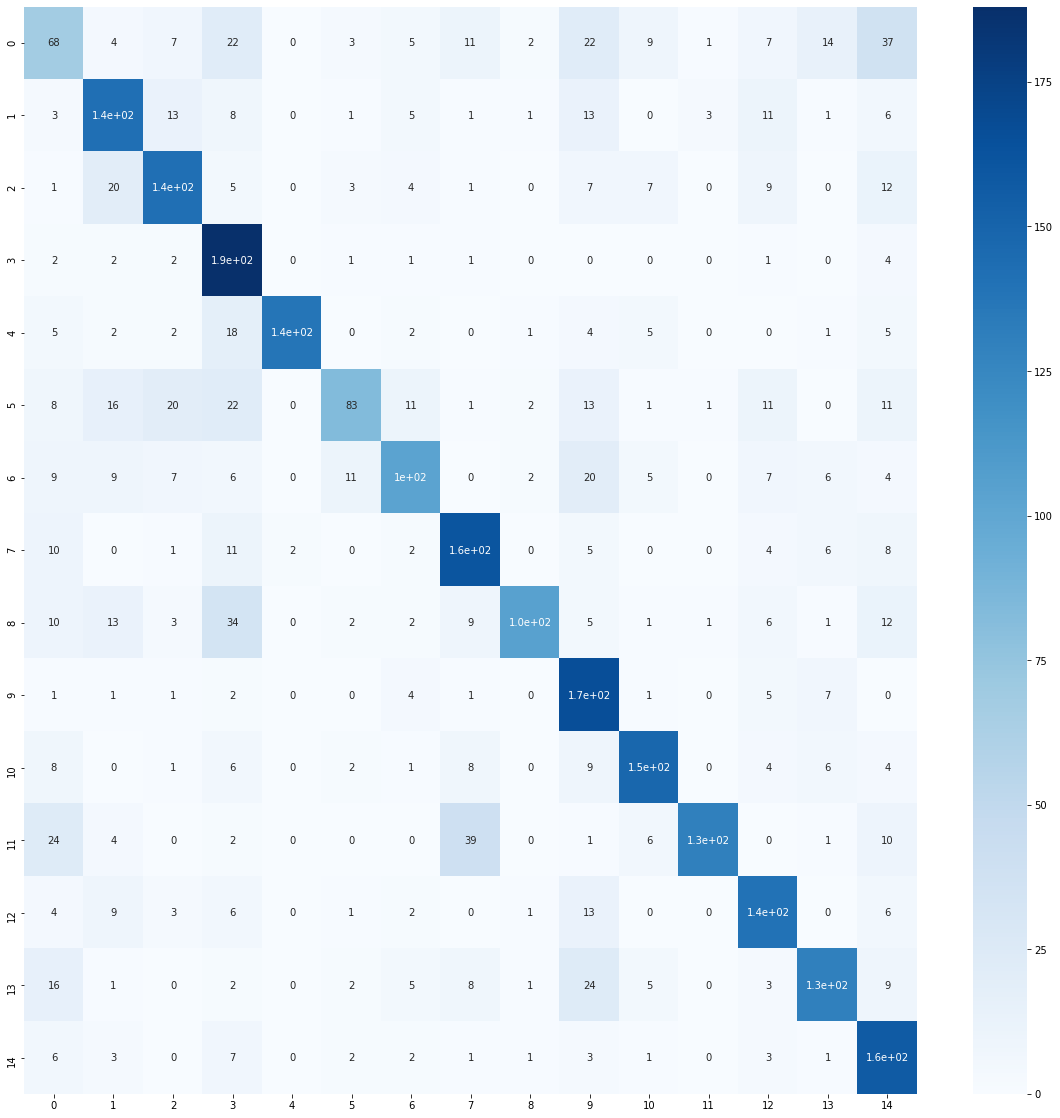

In [ ]:
#We again created a confusion matrix to see where our model struggled for the test set
y_test_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3)
cm=confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, cmap = 'Blues')

'''
This confuson matrix shows that the model had the most innaccuracy in the label 3 column (Guava).  Guava fruit images were being mistaken for Mango(5) and pear (8), whcih is simialr
to the training set.  This makes sense to me shape wise as each of these fruits has a more spherical shape.  I would expect that the color would help to distinguish between these, but it is possible
that less ripe fruit would have a different color appearance which may have caused a lack of success when classifying these fruit images.  In general there were less inaccuracies that stood out
over the others. The mislabeling was fairly evenly distributed
''' 

# Deep Learning (CNN)

In [ ]:
#Load the images to be used for the deep learning model
X,y = load_img(df)

In [ ]:
# splitting X and y into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

In [ ]:
#can see that the model will be trained using 12,000 rows with images 150x150 with color
X_train.shape

(12000, 150, 150, 3)

In [ ]:
# Model / data parameters
num_classes = 15 #There are 15 different fruit categories present in the data
input_shape = (150, 150, 3)  #The images are 150x150 pixels with channel 3 indicatig color

print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

X_train shape: (12000, 150, 150, 3)
12000 train samples
3000 test samples


In [ ]:
#Building the model with the 2 layers and maxpooling.  Using the ReLU activation function
#Max pooling is non-linear down-sampling.  This function takes the input and converts it to rectangles.  
#The maximum value for each rectangle is then found.  The ReLU function goes through the outputs of the convolution layer and replaces
#the negative values with a 0.  The ReLU function is an activation function

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dropout (Dropout)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 15)                1

In [ ]:
#Training and fitting the model to be used to predict labeling
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
85/85 [==============================] - 290s 3s/step - loss: 152.4757 - accuracy: 0.3504 - val_loss: 0.5493 - val_accuracy: 0.8308
Epoch 2/15
85/85 [==============================] - 287s 3s/step - loss: 0.3454 - accuracy: 0.8904 - val_loss: 0.4448 - val_accuracy: 0.8567
Epoch 3/15
85/85 [==============================] - 286s 3s/step - loss: 0.1704 - accuracy: 0.9467 - val_loss: 0.4377 - val_accuracy: 0.8633
Epoch 4/15
85/85 [==============================] - 287s 3s/step - loss: 0.1109 - accuracy: 0.9618 - val_loss: 0.6850 - val_accuracy: 0.8517
Epoch 5/15
85/85 [==============================] - 288s 3s/step - loss: 0.1131 - accuracy: 0.9637 - val_loss: 0.6455 - val_accuracy: 0.8667
Epoch 6/15
85/85 [==============================] - 288s 3s/step - loss: 0.0740 - accuracy: 0.9775 - val_loss: 0.5480 - val_accuracy: 0.8633
Epoch 7/15
85/85 [==============================] - 287s 3s/step - loss: 0.0693 - accuracy: 0.9798 - val_loss: 0.6229 - val_accuracy: 0.8817
Epoch 8/15


**RBM With Linear Regression**

In [ ]:
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import minmax_scale

In [ ]:
def load_img_greyscale(df):
# Load the images using their contained in the dataframe df
# Return a list of images and a list with the labels of the images
    img_paths = df["path"].values
    img_labels = df["label"].values
    x = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  cv2.imread(path)
        img =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (28,28))
        label = img_labels[i]
        x.append(img)
        y.append(label)
    return np.array(x),np.array(y)

In [ ]:
x,y = load_img_greyscale(df)

In [ ]:
#x = np.asarray(x, 'float32')

In [ ]:
#x = minmax_scale(x, feature_range=(0, 1))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1) #splitting our data

In [ ]:
x_train = x_train.reshape(12000,28*28)
x_test = x_test.reshape(3000, 28*28)

In [ ]:
x_train = (x_train - np.min(x_train, 0)) / (np.max(x_train, 0) + 0.0001) # Scaling

In [ ]:
# Modeling and training

rbm = BernoulliRBM(learning_rate=.01, n_iter=20, n_components=150,verbose=True)
logistic = LogisticRegression( solver='newton-cg',
                 max_iter=10000,C=6000, multi_class='multinomial')

rbm.fit(x_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -506.47, time = 5.05s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -495.69, time = 5.59s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -490.38, time = 5.52s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -491.28, time = 5.45s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -482.69, time = 5.61s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -484.41, time = 5.58s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -479.93, time = 5.57s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -479.37, time = 5.64s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -483.06, time = 5.80s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -478.85, time = 5.69s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -476.79, time = 5.45s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -475.03, time = 5.34s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -473.27, time = 5.28s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -476.55, time = 5.30s
[BernoulliRBM] 

BernoulliRBM(batch_size=10, learning_rate=0.01, n_components=150, n_iter=20,
             random_state=None, verbose=True)

In [ ]:
#Combine the two into a Pipeline
rbm_features_classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

In [ ]:
rbm_features_classifier.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.01,
                              n_components=150, n_iter=20, random_state=None,
                              verbose=0)),
                ('logistic',
                 LogisticRegression(C=6000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='newton-cg', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
Y_pred = rbm_features_classifier.predict(x_test)

from sklearn import metrics
print("Logistic regression using RBM features:\n%s\n" % (metrics.classification_report(y_test, Y_pred)))

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.29      0.06      0.09       212
           1       0.42      0.10      0.16       208
           2       0.30      0.04      0.07       211
           3       0.39      0.53      0.45       202
           4       0.21      0.84      0.34       183
           5       0.21      0.09      0.12       200
           6       0.22      0.07      0.11       189
           7       0.33      0.55      0.41       210
           8       0.30      0.20      0.24       204
           9       0.35      0.65      0.45       189
          10       0.27      0.32      0.29       197
          11       0.45      0.65      0.54       217
          12       0.82      0.26      0.40       185
          13       0.43      0.38      0.40       206
          14       0.47      0.28      0.35       187

    accuracy                           0.33      3000
   macro avg       0.36      0.34      0

**Logistic without rbm**

In [ ]:
# 
from sklearn.base import clone

L_classifier = clone(logistic)
L_classifier.C = 100.
L_classifier.fit(x_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Evaluation

y_pred = L_classifier.predict(x_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(y_test, y_pred)))

Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.69      0.19      0.30       212
           1       0.75      0.37      0.49       208
           2       1.00      0.09      0.17       211
           3       0.50      0.95      0.65       202
           4       0.35      0.92      0.51       183
           5       0.75      0.26      0.38       200
           6       0.92      0.13      0.22       189
           7       0.59      0.69      0.64       210
           8       0.46      0.70      0.55       204
           9       0.31      0.85      0.46       189
          10       0.87      0.39      0.54       197
          11       0.59      1.00      0.75       217
          12       0.97      0.16      0.27       185
          13       0.55      0.62      0.58       206
          14       0.83      0.39      0.53       187

    accuracy                           0.51      3000
   macro avg       0.68      0.51 

ValueError: ignored

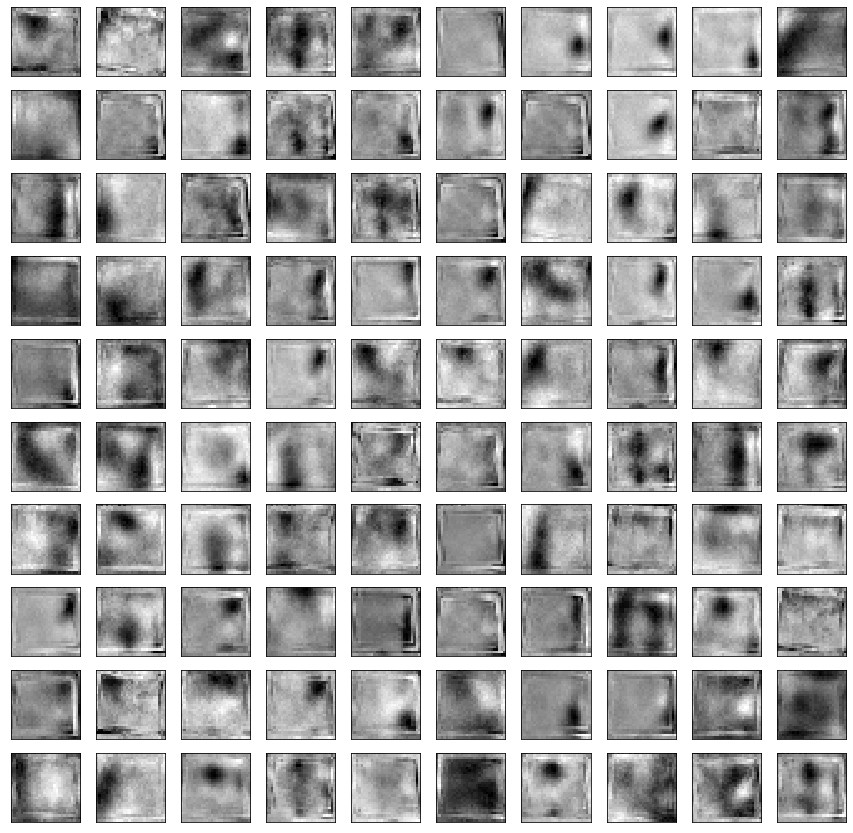

In [ ]:
plt.figure(figsize=(15, 15))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i+1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

# RBM SGD Classifier

In [ ]:
#Transform the x_train set into the rbm model
x_RBM = rbm.fit_transform(x_train)

In [ ]:
#The x_train should now have a reduced size to 150, which was indicated in the RBM model
x_RBM.shape

(12000, 150)

In [ ]:
#Took the x_train that was transformed using the RBM with 150 components.
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(x_RBM, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
#Checked the accuracy of the classifier.  The results showed that this model could range from 0.45-0.51 accuracy, which is much lower than the original dataset prior to using RBM
#This suggests that more features may be needed to accurately predict the fruit images
cross_val_score(sgd_clf, x_RBM, y_train, cv=3, scoring="accuracy")

array([0.45975, 0.51075, 0.50425])

**RBM-Linear Regression**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale
from sklearn.base import clone
